Cette page doit être lancée sur Kaggle, depuis la compétition pour avoir accès aux données. Sinon vous devez récupérer les données séparément.

In [1]:
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt# data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.display import FileLink
import yaml
SEED = 25
np.random.seed(SEED)
tf.random.set_seed(SEED)
OUTPUT_DIR = '/kaggle/working/outputs'
strategy = tf.distribute.MirroredStrategy()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5

  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def save_config(dictionnaire, chemin_fichier='config.yml'):
    with open(chemin_fichier, 'w') as fichier:
        yaml.dump(dictionnaire, fichier)
    print("Fichier YAML sauvegardé avec succès.")
def read_yaml(chemin_fichier):
    if os.path.exists(chemin_fichier):
        with open(chemin_fichier, 'r') as fichier:
            contenu = yaml.safe_load(fichier)
    else:
        contenu = {}
    return contenu

In [3]:
config = {}

## Lire les images

cf https://keras.io/api/data_loading/image/ et 
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [4]:
config['output_file'] = 'submission.csv' if config.get('output_file') == None else config.get('output_file')
config['BATCH_SIZE'] = 128 if config.get('BATCH_SIZE') == None else config.get('BATCH_SIZE')
config['epochs'] = 150 if config.get('epochs') == None else config.get('epochs')


In [5]:
directory_path = "/kaggle/input/navires-2023-la-mano/ships16x24/ships_16x24_10cat/data"
ds_train, ds_val = tf.keras.utils.image_dataset_from_directory(directory_path, labels='inferred',subset='both',shuffle=True,validation_split=0.2,seed=SEED,image_size=(16,24), batch_size=config['BATCH_SIZE'])


Found 35515 files belonging to 10 classes.

Using 28412 files for training.

Using 7103 files for validation.


In [6]:
ds_train

<BatchDataset element_spec=(TensorSpec(shape=(None, 16, 24, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Résultat à soumettre

In [7]:
class CheckValidationLossCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, patience=0):
        self.patience = patience
        self.counter = 0

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        train_loss = logs.get('loss')
        if val_loss < train_loss:
            self.counter = 0
            print(f"\nValidation loss ({val_loss:.4f}) is less than training loss ({train_loss:.4f})")
        else:
            self.counter +=1
            
        if(self.counter == self.patience):
            self.model.stop_training = True

In [8]:
def test_phase(model):
    file_name = config['output_file']
    X_test = np.load('/kaggle/input/navires-2023-la-mano/test.npy', allow_pickle=True)
    X_test = X_test.astype('float32')
    res = model.predict(X_test).argmax(axis=1)
    df = pd.DataFrame({"Category":res})
    df.to_csv(os.path.join(file_name), index_label="Id")

def save_history(model,history):
    history_df = pd.DataFrame(history.history)
    hist_file_name = f"history_{model.name}.csv"
    history_df.to_csv(os.path.join(hist_file_name))

def save_model(model):
    model_file_name = f"{model.name}.h5"
    model.save(os.path.join(model_file_name))

In [9]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout,Flatten, Dense, BatchNormalization, Rescaling, LeakyReLU,AveragePooling2D,RandomFlip,RandomRotation, Rescaling
from tensorflow.keras.models import load_model

def build_model(input_shape=(16, 24, 3), num_classes=10) -> Model:
    model = Sequential([
        
        Conv2D(32, 3, padding='same', input_shape=input_shape,activation='relu'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.25),
        #MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, (3, 3), padding='same',activation='relu'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        
        Conv2D(128, (3, 3), padding='same',activation='relu'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.7),
        
        Flatten(),
        Dense(256,activation='relu'),
        LeakyReLU(alpha=0.6),
        BatchNormalization(),
        Dropout(0.675),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model
with strategy.scope():
    model = build_model()
config['model_config'] = model.get_config()
model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 16, 24, 32)        896       

                                                                 

 leaky_re_lu (LeakyReLU)     (None, 16, 24, 32)        0         

                                                                 

 batch_normalization (BatchN  (None, 16, 24, 32)       128       

 ormalization)                                                   

                                                                 

 dropout (Dropout)           (None, 16, 24, 32)        0         

                                                                 

 conv2d_1 (Conv2D)           (None, 16, 24, 128)       36992     

                                                                 

 leaky_re_lu_1 (LeakyReLU)   (None, 16, 24, 128)       0         

                                        

Epoch 1/125


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?

  output, from_logits = _get_logits(

2023-05-20 20:50:11.188928: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


444/444 [==============================] - 67s 125ms/step - loss: 2.5612 - accuracy: 0.2540 - val_loss: 1.7179 - val_accuracy: 0.4095

Epoch 2/125

444/444 [==============================] - 14s 31ms/step - loss: 1.8353 - accuracy: 0.3773 - val_loss: 1.5700 - val_accuracy: 0.4495

Epoch 3/125

444/444 [==============================] - 14s 31ms/step - loss: 1.6341 - accuracy: 0.4327 - val_loss: 1.5088 - val_accuracy: 0.4675

Epoch 4/125

444/444 [==============================] - 14s 31ms/step - loss: 1.5497 - accuracy: 0.4667 - val_loss: 1.4811 - val_accuracy: 0.4761

Epoch 5/125

444/444 [==============================] - 14s 31ms/step - loss: 1.4830 - accuracy: 0.4888 - val_loss: 1.3602 - val_accuracy: 0.5156

Epoch 6/125

444/444 [==============================] - 17s 38ms/step - loss: 1.4401 - accuracy: 0.5015 - val_loss: 1.2561 - val_accuracy: 0.5596

Epoch 7/125

444/444 [==============================] - 14s 31ms/step - loss: 1.3992 - accuracy: 0.5169 - val_loss: 1.2315 - val_a

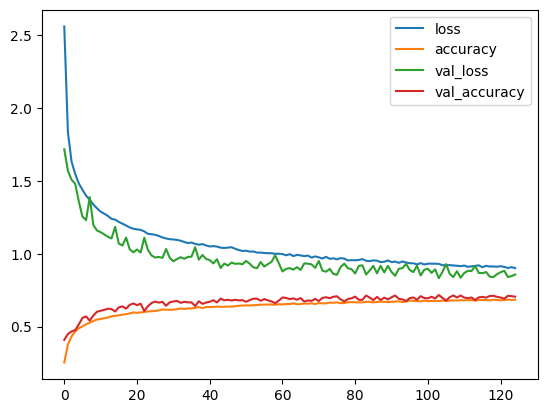

In [10]:
MODEL_FILE_NAME = 'model.h5'
def train_and_test(model=None,**kwargs):
    callbacks = []
    epochs = kwargs['epochs']
    #callbacks.append(CheckValidationLossCallback(patience=3))
    callbacks.append(tf.keras.callbacks.ModelCheckpoint(MODEL_FILE_NAME))
    if model is None:
        model = build_model() 
    history = model.fit(ds_train,epochs=epochs,validation_data=ds_val,callbacks=callbacks)
    test_phase(model)
    save_model(model)
    save_history(model,history)
    return history

history = train_and_test(**config)
model = load_model(MODEL_FILE_NAME)
test_phase(model)
save_model(model)

pd.DataFrame(history.history).plot()
plt.show()

In [11]:
test_phase(model)
FileLink(config['output_file'])

116/116 [==============================] - 0s 2ms/step


/kaggle/working/submission.csv

In [12]:
save_config(config,'config.yml')

Fichier YAML sauvegardé avec succès.


In [13]:
!rm -rf ships32/

In [14]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  20
